# Run from ../scripts

In [31]:
%cd ../scripts

/nfs/ghome/live/rapela/dev/research/gatsby-swc/gatsby/svGPFA/pythonCode/scripts


# Import requirements

In [32]:
import sys
import os
import pdb
import math
import random
import torch
import pickle
import configparser
import pandas as pd
import sklearn.metrics
import matplotlib.pyplot as plt
import IPython.core.display

sys.path.append("../src")
import stats.svGPFA.svGPFAModelFactory
import stats.svGPFA.svEM
import plot.svGPFA.plotUtils
import plot.svGPFA.plotUtilsPlotly
import utils.svGPFA.configUtils
import stats.svGPFA.svGPFAModelFactory

import stats.pointProcess.tests
import utils.svGPFA.miscUtils
import utils.svGPFA.initUtils

# Load data

In [33]:
simResNumber = 96652136
simResConfigFilename = "results/{:08d}_simulation_metaData.ini".format(simResNumber)
simResConfig = configparser.ConfigParser()
simResConfig.read(simResConfigFilename)
simInitConfigFilename = simResConfig["simulation_params"]["simInitConfigFilename"]
simResFilename = simResConfig["simulation_results"]["simResFilename"]

simInitConfig = configparser.ConfigParser()
simInitConfig.read(simInitConfigFilename)
nLatents = int(simInitConfig["control_variables"]["nLatents"])
nNeurons = int(simInitConfig["control_variables"]["nNeurons"])
dtCIF = float(simInitConfig["control_variables"]["dtCIF"])                                                                          
CFilename = simInitConfig["embedding_params"]["C_filename"]
dFilename = simInitConfig["embedding_params"]["d_filename"]
trueC, trueD = utils.svGPFA.configUtils.getLinearEmbeddingParams(CFilename=CFilename, dFilename=dFilename)                                
trialsLengths = [float(str) for str in simInitConfig["control_variables"]["trialsLengths"][1:-1].split(",")]
nTrials = len(trialsLengths)

with open(simResFilename, "rb") as f: simRes = pickle.load(f)
spikesTimes = simRes["spikes"]
trueCIFValues = simRes["cifValues"]
trueLatentsTimes = simRes["times"]
trueLatentsSamples = simRes["latents"]
trueLatentsMeans = simRes["latentsMeans"]
trueLatentsSTDs = simRes["latentsSTDs"]
trueLatentsSamples = [trueLatentsSamples[r][:nLatents,:] for r in range(nTrials)]
trueLatentsMeans = [trueLatentsMeans[r][:nLatents,:] for r in range(nTrials)]
trueLatentsSTDs = [trueLatentsSTDs[r][:nLatents,:] for r in range(nTrials)]
trueIndPointsLocs = utils.svGPFA.configUtils.getIndPointsLocs0(nLatents=nLatents, nTrials=nTrials, config=simInitConfig)
trueKernels = utils.svGPFA.configUtils.getKernels(nLatents=nLatents, config=simInitConfig, forceUnitScale=False)

# tEmbeddingSamples[r], tEmbeddingMeans[r], tEmbeddingSTDs \in nNeurons x nSamples
trueEmbeddingSamples = [torch.matmul(trueC, trueLatentsSamples[r])+trueD for r in range(nTrials)]
trueEmbeddingMeans = [torch.matmul(trueC, trueLatentsMeans[r])+trueD for r in range(nTrials)]
trueEmbeddingSTDs = [torch.matmul(trueC, trueLatentsSTDs[r]) for r in range(nTrials)]


# Set parameters initial values

In [34]:
nQuad = 200
nIndPoints = 30

# set variational mean initial values
qMu0 = [[] for r in range(nLatents)]
for k in range(nLatents):
    qMu0[k] = torch.empty((nTrials, nIndPoints, 1), dtype=torch.double)
    for r in range(nTrials):
        qMu0[k][r,:,0] = torch.zeros(size=(nIndPoints,), dtype=torch.double)

# set variational covariance initial values
qSigma0 = [[] for r in range(nLatents)]
for k in range(nLatents):
    qSigma0[k] = torch.empty((nTrials, nIndPoints, nIndPoints), dtype=torch.double)
    for r in range(nTrials):
        qSigma0[k][r,:,:] = 1e-2*torch.eye(n=nIndPoints, dtype=torch.double)
srQSigma0Vecs = utils.svGPFA.initUtils.getSRQSigmaVecsFromSRMatrices(srMatrices=qSigma0)

# set embedding initial values
C0 = torch.randn(size=(nNeurons, nLatents), dtype=torch.double)*0.3
d0 = torch.randn(size=(nNeurons,), dtype=torch.double)*0.3

# set kernels initial values
kernel0 = stats.kernels.ExponentialQuadraticKernel(scale=1.0)
kernel0.setParams([2.0])
kernel1 = stats.kernels.ExponentialQuadraticKernel(scale=1.0)
kernel1.setParams([0.1])
kernels = [kernel0, kernel1]
kernelsScaledParams0 = utils.svGPFA.initUtils.getKernelsScaledParams0(kernels=kernels, noiseSTD=0.0)

# set inducing points locations initial values
Z0 = [[] for k in range(nLatents)]
for k in range(nLatents):
    Z0[k] = torch.empty((nTrials, nIndPoints, 1), dtype=torch.double)
    for r in range(nTrials):
        Z0[k][r,:,0] = torch.rand(size=(nIndPoints,), dtype=torch.double)

# set quadrature points params
legQuadPoints, legQuadWeights = utils.svGPFA.miscUtils.getLegQuadPointsAndWeights(nQuad=nQuad, trialsLengths=trialsLengths)

qUParams0 = {"qMu0": qMu0, "srQSigma0Vecs": srQSigma0Vecs}
kmsParams0 = {"kernelsParams0": kernelsScaledParams0,
              "inducingPointsLocs0": Z0}
qKParams0 = {"svPosteriorOnIndPoints": qUParams0,
             "kernelsMatricesStore": kmsParams0}
qHParams0 = {"C0": C0, "d0": d0}
initialParams = {"svPosteriorOnLatents": qKParams0,
                 "svEmbedding": qHParams0}
quadParams = {"legQuadPoints": legQuadPoints,
              "legQuadWeights": legQuadWeights}


# Create model

In [35]:
indPointsLocsKMSRegEpsilon = 1e-5

# create model
model = stats.svGPFA.svGPFAModelFactory.SVGPFAModelFactory.buildModel(
    conditionalDist=stats.svGPFA.svGPFAModelFactory.PointProcess,
    linkFunction=stats.svGPFA.svGPFAModelFactory.ExponentialLink,
    embeddingType=stats.svGPFA.svGPFAModelFactory.LinearEmbedding,
    kernels=kernels)

model.setInitialParamsAndData(measurements=spikesTimes,
                              initialParams=initialParams,
                              quadParams=quadParams,
                              indPointsLocsKMSRegEpsilon=indPointsLocsKMSRegEpsilon)


# Set the optimization parameters

In [36]:
optimMethod = "EM"

# set EM optimization parameters
optimParams = dict(
    em_max_iter = 50,
    #
    estep_estimate = True,
    estep_optim_params = dict(
        max_iter = 20,
        lr = 1.0,
        tolerance_grad = 1e-7,
        tolerance_change = 1e-9,
        line_search_fn ="strong_wolfe"
    ),
    #
    mstep_embedding_estimate = True,
    mstep_embedding_optim_params = dict(
        max_iter = 20,
        lr = 1.0,
        tolerance_grad = 1e-7,
        tolerance_change = 1e-9,
        line_search_fn ="strong_wolfe"
    ),
    #
    mstep_kernels_estimate = True,
    mstep_kernels_optim_params = dict(
        max_iter = 20,
        lr = 1.0,
        tolerance_grad = 1e-7,
        tolerance_change = 1e-9,
        line_search_fn ="strong_wolfe"
    ),
    #
    mstep_indpointslocs_estimate = True,
    mstep_indpointslocs_optim_params = dict(
        max_iter = 20,
        lr = 1.0,
        tolerance_grad = 1e-7,
        tolerance_change = 1e-9,
        line_search_fn ="strong_wolfe"
    ),
    verbose = True
)

# Maximize the Lower Bound
<span style="color:red">(Warning: with the parameters above, this step takes around 15 minutes)</span>

In [37]:
svEM = stats.svGPFA.svEM.SVEM()
lowerBoundHist, elapsedTimeHist, terminationInfo, iterationsModelParams  = svEM.maximize(model=model, optimParams=optimParams, method=optimMethod)


Iteration 01, estep start: -inf
Iteration 01, estep end: -514.755590, niter: 20, nfeval: 22
Iteration 01, mstep_embedding start: -514.755590
Iteration 01, mstep_embedding end: 135881.553051, niter: 18, nfeval: 25
Iteration 01, mstep_kernels start: 135881.553051
Kernel params: [tensor([1.9404]), tensor([0.0863])]
Iteration 01, mstep_kernels end: 135407.253970, niter: 20, nfeval: 23
Iteration 01, mstep_indpointslocs start: 135407.253970
Iteration 01, mstep_indpointslocs end: 135690.528789, niter: 19, nfeval: 25
Iteration 02, estep start: 135690.528789
Iteration 02, estep end: 142217.214081, niter: 20, nfeval: 25
Iteration 02, mstep_embedding start: 142217.214081
Iteration 02, mstep_embedding end: 151530.075296, niter: 20, nfeval: 22
Iteration 02, mstep_kernels start: 151530.075296
Kernel params: [tensor([1.1808]), tensor([0.0638])]
Iteration 02, mstep_kernels end: 150368.791115, niter: 16, nfeval: 25
Iteration 02, mstep_indpointslocs start: 150368.791115
Iteration 02, mstep_indpointslocs

Iteration 16, mstep_indpointslocs end: 157516.034488, niter: 20, nfeval: 24
Iteration 17, estep start: 157516.034488
Iteration 17, estep end: 157543.711770, niter: 20, nfeval: 22
Iteration 17, mstep_embedding start: 157543.711770
Iteration 17, mstep_embedding end: 158071.372662, niter: 20, nfeval: 22
Iteration 17, mstep_kernels start: 158071.372662
Kernel params: [tensor([0.4166]), tensor([0.0592])]
Iteration 17, mstep_kernels end: 157545.054872, niter: 10, nfeval: 18
Iteration 17, mstep_indpointslocs start: 157545.054872
Iteration 17, mstep_indpointslocs end: 157550.332998, niter: 20, nfeval: 23
Iteration 18, estep start: 157550.332998
Iteration 18, estep end: 157575.323704, niter: 20, nfeval: 23
Iteration 18, mstep_embedding start: 157575.323704
Iteration 18, mstep_embedding end: 158103.115182, niter: 20, nfeval: 21
Iteration 18, mstep_kernels start: 158103.115182
Kernel params: [tensor([0.4125]), tensor([0.0595])]
Iteration 18, mstep_kernels end: 157576.831040, niter: 12, nfeval: 20

Kernel params: [tensor([0.3399]), tensor([0.0704])]
Iteration 32, mstep_kernels end: 157931.624830, niter: 12, nfeval: 16
Iteration 32, mstep_indpointslocs start: 157931.624830
Iteration 32, mstep_indpointslocs end: 157933.800032, niter: 20, nfeval: 23
Iteration 33, estep start: 157933.800032
Iteration 33, estep end: 157948.105421, niter: 20, nfeval: 23
Iteration 33, mstep_embedding start: 157948.105421
Iteration 33, mstep_embedding end: 158501.619124, niter: 20, nfeval: 23
Iteration 33, mstep_kernels start: 158501.619124
Kernel params: [tensor([0.3379]), tensor([0.0713])]
Iteration 33, mstep_kernels end: 157949.420909, niter: 12, nfeval: 16
Iteration 33, mstep_indpointslocs start: 157949.420909
Iteration 33, mstep_indpointslocs end: 157951.499201, niter: 20, nfeval: 22
Iteration 34, estep start: 157951.499201
Iteration 34, estep end: 157964.019348, niter: 20, nfeval: 23
Iteration 34, mstep_embedding start: 157964.019348
Iteration 34, mstep_embedding end: 158518.650266, niter: 20, nfev

Iteration 48, estep end: 158092.285446, niter: 20, nfeval: 22
Iteration 48, mstep_embedding start: 158092.285446
Iteration 48, mstep_embedding end: 158643.517940, niter: 20, nfeval: 23
Iteration 48, mstep_kernels start: 158643.517940
Kernel params: [tensor([0.3215]), tensor([0.0846])]
Iteration 48, mstep_kernels end: 158092.787567, niter: 7, nfeval: 13
Iteration 48, mstep_indpointslocs start: 158092.787567
Iteration 48, mstep_indpointslocs end: 158093.213144, niter: 20, nfeval: 24
Iteration 49, estep start: 158093.213144
Iteration 49, estep end: 158097.240937, niter: 20, nfeval: 22
Iteration 49, mstep_embedding start: 158097.240937
Iteration 49, mstep_embedding end: 158647.570389, niter: 20, nfeval: 24
Iteration 49, mstep_kernels start: 158647.570389
Kernel params: [tensor([0.3213]), tensor([0.0855])]
Iteration 49, mstep_kernels end: 158097.853144, niter: 7, nfeval: 12
Iteration 49, mstep_indpointslocs start: 158097.853144
Iteration 49, mstep_indpointslocs end: 158098.267273, niter: 20

# Set neuron, latent and trial to plot

In [38]:
neuronToPlot = 0
trialToPlot = 0
latentToPlot = 0

# Plot lower bound history

In [39]:
fig = plot.svGPFA.plotUtilsPlotly.getPlotLowerBoundHist(lowerBoundHist=lowerBoundHist)
fig.show()
# IPython.display.HTML(fig.to_html())

# KS time-rescaling GOF test -- numerical correction

Processing given ISIs
Processing iter 0/9
Processing iter 1/9
Processing iter 2/9
Processing iter 3/9
Processing iter 4/9
Processing iter 5/9
Processing iter 6/9
Processing iter 7/9
Processing iter 8/9
Processing iter 9/9


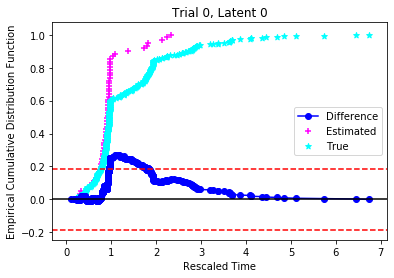

In [40]:
# KS test time rescaling with numerical correction
ksTestGamma = 10
T = torch.tensor(trialsLengths).max()
oneTrialCIFTimes = torch.arange(0, T, dtCIF)
cifTimes = torch.unsqueeze(torch.ger(torch.ones(nTrials), oneTrialCIFTimes), dim=2)
spikesTimesKS = spikesTimes[trialToPlot][neuronToPlot]
cifTimesKS = cifTimes[trialToPlot,:,0]
with torch.no_grad():
    epmcifValues = model.computeExpectedCIFs(times=cifTimes)
cifValuesKS = epmcifValues[trialToPlot][neuronToPlot]
title = "Trial {:d}, Latent {:d}".format(trialToPlot, latentToPlot)
diffECDFsX, diffECDFsY, estECDFx, estECDFy, simECDFx, simECDFy, cb = stats.pointProcess.tests.KSTestTimeRescalingNumericalCorrection(spikesTimes=spikesTimesKS, cifTimes=oneTrialCIFTimes, cifValues=cifValuesKS, gamma=ksTestGamma)
plot.svGPFA.plotUtils.plotResKSTestTimeRescalingNumericalCorrection(diffECDFsX=diffECDFsX, diffECDFsY=diffECDFsY, estECDFx=estECDFx, estECDFy=estECDFy, simECDFx=simECDFx, simECDFy=simECDFy, cb=cb, title=title)

# ROC predictive analysis

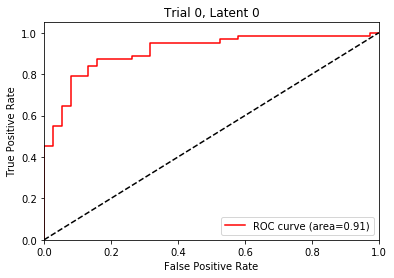

In [41]:
# ROC predictive analysis
cifTimesKS = cifTimes[trialToPlot,:,0]
with torch.no_grad():
    epmcifValues = model.computeExpectedCIFs(times=cifTimes)
cifValuesKS = epmcifValues[trialToPlot][neuronToPlot]
pk = cifValuesKS*dtCIF
bins = pd.interval_range(start=0, end=int(T), periods=len(pk))
cutRes, _ = pd.cut(spikesTimesKS.tolist(), bins=bins, retbins=True)
Y = torch.from_numpy(cutRes.value_counts().values)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(Y, pk, pos_label=1)
roc_auc = sklearn.metrics.auc(fpr, tpr)
title = "Trial {:d}, Latent {:d}".format(trialToPlot, latentToPlot)
plot.svGPFA.plotUtils.plotResROCAnalysis(fpr=fpr, tpr=tpr, auc=roc_auc, title=title)

# Predict and plot true and estimated latents

In [42]:
eTimes = trueLatentsTimes
with torch.no_grad():
    eLatentsMeans, eLatentsSTDs = model.predictLatents(newTimes=eTimes[0])

tLatentsSamplesToPlot = trueLatentsSamples[trialToPlot][latentToPlot,:]
tLatentsMeansToPlot = trueLatentsMeans[trialToPlot][latentToPlot,:]
tLatentsSTDsToPlot = trueLatentsSTDs[trialToPlot][latentToPlot,:]
eLatentsMeansToPlot = eLatentsMeans[trialToPlot,:,latentToPlot]
eLatentsSTDsToPlot = eLatentsSTDs[trialToPlot,:,latentToPlot]
title = "Trial {:d}, Latent {:d}".format(trialToPlot, latentToPlot)
fig = plot.svGPFA.plotUtilsPlotly.getPlotTrueAndEstimatedLatentsOneTrialOneLatent(
    tTimes = trueLatentsTimes[0],
    tLatentsSamples=tLatentsSamplesToPlot,
    tLatentsMeans=tLatentsMeansToPlot,
    tLatentsSTDs=tLatentsSTDsToPlot,
    eTimes=eTimes[0],
    eLatentsMeans=eLatentsMeansToPlot,
    eLatentsSTDs=eLatentsSTDsToPlot,
    title=title,
)
fig.show()
# IPython.display.HTML(fig.to_html())

# Plot true and estimated linear embedding parameters

In [43]:
tTimesToPlot = trueLatentsTimes[trialToPlot]
tSamplesToPlot = trueEmbeddingSamples[trialToPlot][neuronToPlot,:]                                                                     
tMeansToPlot = trueEmbeddingMeans[trialToPlot][neuronToPlot,:]
tSTDsToPlot = trueEmbeddingSTDs[trialToPlot][neuronToPlot,:]

eTimes = torch.unsqueeze(torch.ger(torch.ones(nTrials), trueLatentsTimes[0]), dim=2)
eEmbeddingMeans, eEmbeddingVars = model.computeEmbeddingMeansAndVarsAtTimes(times=eTimes)
eTimesToPlot = eTimes[trialToPlot,:,0]
eMeansToPlot = eEmbeddingMeans[trialToPlot,:,neuronToPlot]
eSTDsToPlot = eEmbeddingVars[trialToPlot,:,neuronToPlot].sqrt()

title = "Trial {:d}, Neuron {:d}".format(trialToPlot, neuronToPlot)
fig = plot.svGPFA.plotUtilsPlotly.getPlotTrueAndEstimatedEmbedding(tTimes=tTimesToPlot, tSamples=tSamplesToPlot, tMeans=tMeansToPlot, tSTDs=tSTDsToPlot, eTimes=eTimesToPlot, eMeans=eMeansToPlot, eSTDs=eSTDsToPlot, title=title)
fig.show()
# IPython.display.HTML(fig.to_html())

# Plot true and estimated CIFs

In [44]:
tTimesToPlot = trueLatentsTimes[trialToPlot]
tCIFValuesToPlot = trueCIFValues[trialToPlot][neuronToPlot]
T = torch.tensor(trialsLengths).max()
oneTrialCIFTimes = torch.arange(0, T, dtCIF)
cifTimes = torch.unsqueeze(torch.ger(torch.ones(nTrials), oneTrialCIFTimes), dim=2)

with torch.no_grad():
    epmcifValues = model.computeExpectedCIFs(times=cifTimes)
epmcifValuesToPlot = epmcifValues[trialToPlot][neuronToPlot]

title = "Trial {:d}, Neuron {:d}".format(trialToPlot, neuronToPlot)
fig = plot.svGPFA.plotUtilsPlotly.getPlotSimulatedAndEstimatedCIFs(tTimes=tTimesToPlot, tCIF=tCIFValuesToPlot, tLabel="True", eMeanTimes=oneTrialCIFTimes, eMeanCIF=epmcifValuesToPlot, eMeanLabel="Mean", ePosteriorMeanTimes=oneTrialCIFTimes, ePosteriorMeanCIF=epmcifValuesToPlot, ePosteriorMeanLabel="Posterior Mean", title=title)
fig.show()
# IPython.display.HTML(fig.to_html())


# Plot true and estimated linear embedding parameters

In [45]:
estimatedC, estimatedD = model.getSVEmbeddingParams()                                                                               
fig = plot.svGPFA.plotUtilsPlotly.getPlotTrueAndEstimatedEmbeddingParams(trueC=trueC, trueD=trueD, estimatedC=estimatedC, estimatedD=estimatedD)
fig.show()
# IPython.display.HTML(fig.to_html())


# Plot true and estimated kernels parameters

In [46]:
title = "Latent {:d}".format(latentToPlot)
tKernelToPlot = trueKernels[latentToPlot]
kernelsParams = model.getKernelsParams()
eKernelParamsToPlot = kernelsParams[latentToPlot]
fig = plot.svGPFA.plotUtilsPlotly.getPlotTrueAndEstimatedKernelsParamsOneLatent(trueKernel=tKernelToPlot, estimatedKernelParams=eKernelParamsToPlot, title=title)

fig.show()
# IPython.display.HTML(fig.to_html())